In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [5]:
def get_historical_data(symbol, start_date):
    api_key = 'bf9c188e2a594111bc4144239c8a359d'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

tsla = get_historical_data('TSLA', '2020-01-01')
tsla

,open,high,low,close,volume
datetime,,,,,
2020-01-02,28.30000,28.71,28.11000,28.68000,143375936.0
2020-01-03,29.37000,30.27,29.13000,29.53000,266920720.0
2020-01-06,29.36000,30.10,29.33000,30.10000,152362640.0
2020-01-07,30.76000,31.44,30.22000,31.27000,273137344.0
2020-01-08,31.58000,33.23,31.22000,32.81000,467991360.0
...,...,...,...,...,...
2023-03-21,188.28000,198.00,188.03999,197.58000,153391400.0
2023-03-22,199.30000,200.66,190.95000,191.14999,150376400.0
2023-03-23,195.25999,199.31,188.64999,192.22000,144193900.0


In [6]:
def get_ci(high, low, close, lookback):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(lookback).max()
    lowl = low.rolling(lookback).min()
    ci = 100 * np.log10((atr.rolling(lookback).sum()) / (highh - lowl)) / np.log10(lookback)
    return ci

tsla['ci_14'] = get_ci(tsla['high'], tsla['low'], tsla['close'], 14)
tsla = tsla.dropna()
tsla

,open,high,low,close,volume,ci_14
datetime,,,,,,
2020-01-23,37.62000,38.80,37.04000,38.15000,294765920.0,31.811076
2020-01-24,38.04000,38.26,36.95000,37.65000,215304208.0,32.100824
2020-01-27,36.13000,37.63,35.95000,37.20000,204121232.0,36.964017
2020-01-28,37.90000,38.45,37.21000,37.79000,176827568.0,41.084397
2020-01-29,38.38000,39.32,37.83000,38.73000,273250368.0,41.722297
...,...,...,...,...,...,...
2023-03-21,188.28000,198.00,188.03999,197.58000,153391400.0,51.313840
2023-03-22,199.30000,200.66,190.95000,191.14999,150376400.0,49.193455
2023-03-23,195.25999,199.31,188.64999,192.22000,144193900.0,49.496259


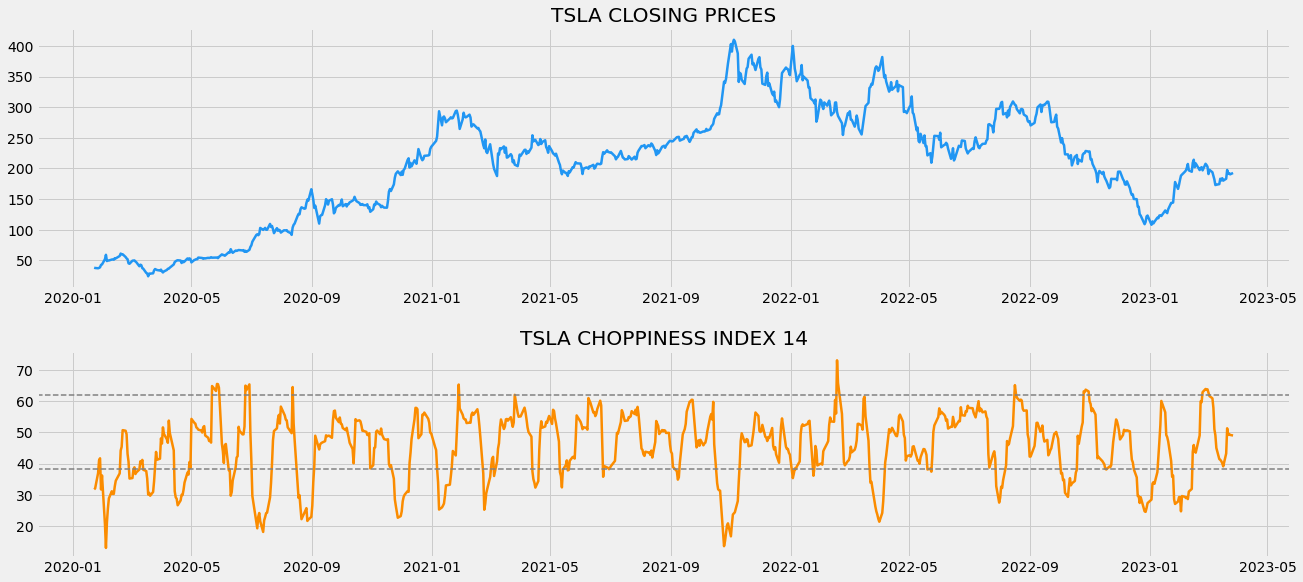

In [7]:
ax1 = plt.subplot2grid((11,1,), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1,), (6,0), rowspan = 4, colspan = 1)
ax1.plot(tsla['close'], linewidth = 2.5, color = '#2196f3')
ax1.set_title('TSLA CLOSING PRICES')
ax2.plot(tsla['ci_14'], linewidth = 2.5, color = '#fb8c00')
ax2.axhline(38.2, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(61.8, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('TSLA CHOPPINESS INDEX 14')
plt.show()